In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
import plotly.graph_objects as go
from PIL import Image
# from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [3]:
df = pd.read_csv('./data_mask.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3909 non-null   object
 1   image_path  3909 non-null   object
 2   mask_path   3909 non-null   object
 3   mask        3909 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.3+ KB


In [5]:
df.head(50)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_4944_20010208,TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif,TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1_...,0
1,TCGA_CS_4944_20010208,TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif,TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1_...,0
2,TCGA_CS_4944_20010208,TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif,TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1_...,0
3,TCGA_CS_4944_20010208,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1_...,0
4,TCGA_CS_4944_20010208,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1_...,0
5,TCGA_CS_4944_20010208,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1_...,0
6,TCGA_CS_4944_20010208,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1_...,0
7,TCGA_CS_4944_20010208,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1_...,0
8,TCGA_CS_4944_20010208,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1_...,0
9,TCGA_CS_4944_20010208,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1_...,0


In [6]:
df['mask'].value_counts()

mask
0    2542
1    1367
Name: count, dtype: int64

In [7]:
df.duplicated().value_counts()

False    3909
Name: count, dtype: int64

## Mini reto

1. ¿Tenemos un dataset balanceado?
2. ¿Cuantas muestras están marcadas como 'paciente sano'?


1. El dataset no esta balanceado con un 65.08% de pacientes sanos y un 34.98% de pacientes con tumores cerebrales en resumen el dataset no esta balanceado

2. 2556 Son pacientes sanos

In [8]:
counts = df['mask'].value_counts()

# Crear figura de barras
fig = go.Figure(data=go.Bar(x=counts.index, y=counts.values))

# Personalizar diseño y estilo
fig.update_layout(
    title='Conteo de valores en la columna "mask"',
    xaxis=dict(title='Valores'),
    yaxis=dict(title='Conteo'),
    hovermode='x'
)

# Mostrar figura interactiva
fig.show()

In [9]:
df['mask_path'].head(50)

0     TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1_...
1     TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1_...
2     TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1_...
3     TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1_...
4     TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1_...
5     TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1_...
6     TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1_...
7     TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1_...
8     TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1_...
9     TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1_...
10    TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1_...
11    TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1_...
12    TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1_...
13    TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1_...
14    TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1_...
15    TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1_...
16    TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1_...
17    TCGA_DU_7309_19960831/TCGA_DU_7309_1996083

In [10]:
df['image_path'].head(50)

0     TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif
1     TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif
2     TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif
3     TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif
4     TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif
5     TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif
6     TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif
7     TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif
8     TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif
9     TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif
10    TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1.tif
11    TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1.tif
12    TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1.tif
13    TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1.tif
14    TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1.tif
15    TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1.tif
16    TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1.tif
17    TCGA_DU_7309_19960831/TCGA_DU_7309_1996083

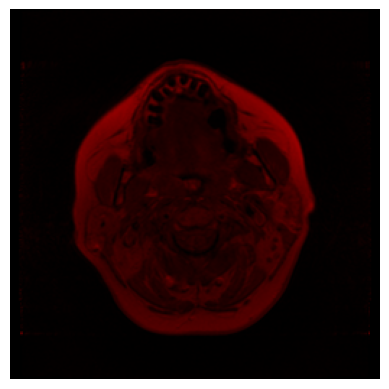

In [11]:
# Ruta de la imagen
ruta_imagen = './TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif'
# Leer la imagen
imagen = plt.imread(ruta_imagen)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Opcional: quitar los ejes
plt.show()

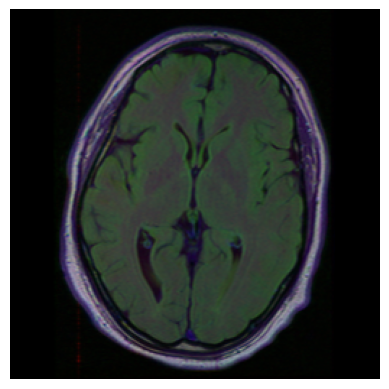

In [12]:
# Ruta de la imagen
ruta_imagen = './TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_10.tif'

# Leer la imagen
imagen = plt.imread(ruta_imagen)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Opcional: quitar los ejes
plt.show()

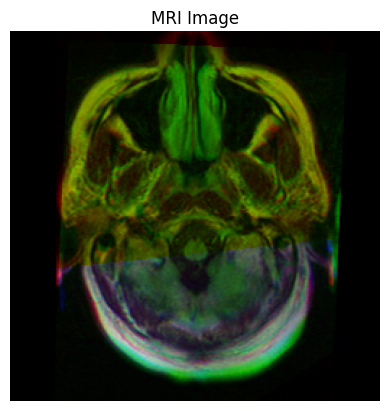

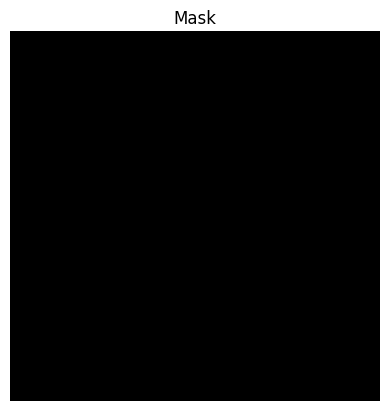

In [13]:
# Supongamos que tienes un dataset de imágenes MRI y máscaras almacenadas en dos listas separadas
mri_images = ['TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif']  # Lista de imágenes MRI
masks = ['TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif']  # Lista de máscaras correspondientes

# Supongamos que quieres visualizar la primera imagen y su máscara correspondiente
mri_image = mri_images[0]
mask = masks[0]

# Cargar la imagen MRI y la máscara
mri = Image.open(mri_image)
mask = Image.open(mask)

# Convertir las imágenes a arrays numpy
mri_array = np.array(mri)
mask_array = np.array(mask)
  
# Visualización de la imagen MRI
plt.figure()
plt.imshow(mri_array, cmap='gray')
plt.title('MRI Image')
plt.axis('off')
plt.show()

# Visualización de la máscara
plt.figure()
plt.imshow(mask_array, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

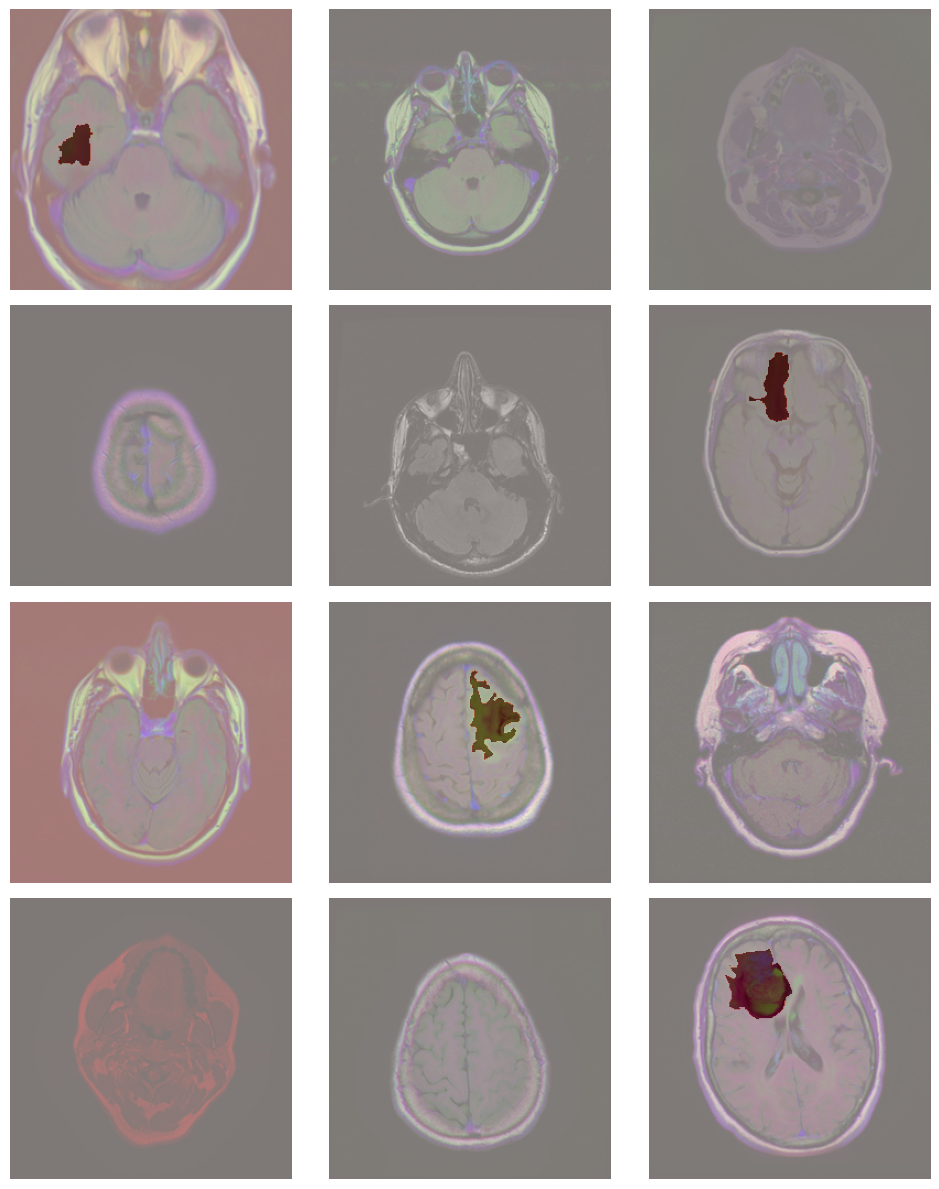

In [14]:
# Seleccionar aleatoriamente 12 muestras del dataset
muestras_aleatorias = df.sample(n=12)

# Crear una figura con subplots de 4 filas y 3 columnas
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

# Iterar sobre los subplots y mostrar las imágenes y máscaras correspondientes
for i, ax in enumerate(axs.flat):
    muestra = muestras_aleatorias.iloc[i]
    
    # Leer la imagen y la máscara correspondiente
    imagen = plt.imread(muestra['image_path'])
    mascara = plt.imread(muestra['mask_path'])
    
    # Mostrar la imagen de MRI
    ax.imshow(imagen, cmap='gray')
    
    # Mostrar la máscara en rojo (superponiendo la imagen de MRI)
    ax.imshow(mascara, cmap='Reds', alpha=0.5)  
    
    # Desactivar los ejes y el etiquetado
    ax.axis('off')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [15]:
def verificar_tamanio_imagenes(imagenes):
    primer_tamanio = None

    for imagen_path in imagenes:
        imagen = Image.open(imagen_path)
        imagen_array = np.array(imagen)

        if primer_tamanio is None:
            primer_tamanio = imagen_array.shape[:2]
        else:
            if imagen_array.shape[:2] != primer_tamanio:
                return False
    
    print(f"Tamaño de la imagen '{imagen_path}': {imagen_array.shape[:2]}")

    return True

# Leer rutas de imágenes desde el archivo CSV
ruta_imagenes = df["image_path"].tolist()

# Verificar si todas las imágenes tienen el mismo tamaño de píxeles
son_similares = verificar_tamanio_imagenes(ruta_imagenes)

if son_similares:
    print("Todas las imágenes tienen el mismo tamaño de píxeles.")
else:
    print("Las imágenes tienen tamaños de píxeles diferentes.")


Tamaño de la imagen 'TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88.tif': (256, 256)
Todas las imágenes tienen el mismo tamaño de píxeles.


## Mini reto tres

1. ¿Cuál es el rendimiento de ResNet en el conjunto de datos ImageNet?

R = ResNet ha demostrado un rendimiento sobresaliente en el conjunto de datos ImageNet. Se han utilizado diferentes variantes de ResNet en competiciones de clasificación de ImageNet, y han obtenido tasas de error muy bajas. Aquí tienes algunos ejemplos de tasas de error reportadas por diferentes variantes de ResNet en la competición ImageNet:

ResNet-18: Error top-1 del 30.24% y error top-5 del 10.92%.
ResNet-34: Error top-1 del 26.70% y error top-5 del 8.58%.
ResNet-50: Error top-1 del 23.85% y error top-5 del 7.13%.
ResNet-101: Error top-1 del 22.63% y error top-5 del 6.44%.
ResNet-152: Error top-1 del 21.69% y error top-5 del 5.94%.
Estas tasas de error representan la precisión de la red, por lo que cuanto más bajo sea el valor, mejor será el rendimiento de la red en la clasificación de imágenes.

2. Explora otras arquitecturas de RNC como AlexNet y enumera su rendimiento en comparación
con ResNet (se requiere investigación externa).

R= AlexNet es una arquitectura de red neuronal convolucional pionera que demostró el poder de las CNN en la clasificación de imágenes en el conjunto de datos ImageNet. Aquí tienes un ejemplo del rendimiento de AlexNet en la competición ImageNet:

AlexNet: Error top-1 del 37.5% y error top-5 del 17.0%.
Comparado con las tasas de error de ResNet que mencioné anteriormente, se puede observar que ResNet supera a AlexNet en términos de precisión en la clasificación de ImageNet. ResNet logró reducir significativamente el error top-1 y el error top-5 en comparación con AlexNet.

Es importante tener en cuenta que estos resultados pueden variar según las configuraciones y los conjuntos de datos utilizados, y que el campo de la visión por computadora está en constante evolución, por lo que pueden haber surgido nuevas arquitecturas y mejoras desde la última información disponible.

### Mini reto cuatro

1. Enumere los desafíos del aprendizaje por transferencia (se requiere investigación externa)

El aprendizaje por transferencia es una técnica en la que los conocimientos adquiridos al resolver un problema se transfieren y aplican para resolver otro problema relacionado. Aunque el aprendizaje por transferencia puede proporcionar beneficios significativos, también presenta algunos desafíos. A continuación, enumero algunos de estos desafíos:

1. Selección del modelo de origen adecuado: Elegir el modelo de origen adecuado para la transferencia es un desafío clave. El modelo de origen debe tener características y conocimientos relevantes para el problema objetivo. La selección incorrecta del modelo de origen puede llevar a una transferencia ineficaz o incluso perjudicial.

2. Divergencia de dominio: La divergencia de dominio ocurre cuando los datos de origen y los datos de destino provienen de distribuciones diferentes. Si hay una gran diferencia entre los dominios, el rendimiento de la transferencia puede verse afectado negativamente. Adaptar el modelo de origen para que se ajuste al dominio del problema objetivo puede ser un desafío.

3. Desajuste de tareas: El desajuste de tareas ocurre cuando la tarea de origen y la tarea objetivo son diferentes. Aunque el aprendizaje por transferencia puede ser efectivo cuando las tareas son similares, el desajuste de tareas puede limitar la transferencia de conocimientos. Es importante encontrar una tarea de origen que sea lo más similar posible a la tarea objetivo para obtener los mejores resultados.

4. Disponibilidad de datos etiquetados: En el aprendizaje por transferencia, es común utilizar datos no etiquetados del dominio de origen junto con datos etiquetados del dominio de destino. Sin embargo, puede ser difícil obtener datos etiquetados en el dominio de destino, lo que limita la capacidad de ajustar el modelo de manera óptima.

5. Interferencia de conocimientos previos: A veces, los conocimientos previos del modelo de origen pueden interferir con la capacidad del modelo para aprender nuevas tareas en el dominio de destino. La transferencia de conocimientos puede ser demasiado fuerte o inapropiada, lo que afecta negativamente el rendimiento en la tarea objetivo.

Estos desafíos demuestran que el aprendizaje por transferencia no es una solución universal y que requiere un cuidadoso análisis y ajuste para lograr los mejores resultados en un nuevo problema.